# Présence du monde de la recherche dans les projets Open Source de Machine Learning : ces projets sont-ils faits par des chercheurs ?

Dans le cadre de notre étude, nous nous interrogeons sur la participation du monde de la recherche au sein des projets Open Source de Machine Learning.

Nos hypothèses sur la question sont les suivantes :
* Les contributeurs ne sont pas majoritairement des chercheurs.
* Les contributions viennent majoritairement de contributeurs-chercheurs (en nombre de *commits* et en nombre de lignes).
* Les contributeurs-chercheurs sont les contributeurs qui contribuent le plus individuellement (en nombre de *commits* et en nombre de lignes).

Les hypothèses de travail que nous posons concernent la bonne foi des contributeurs dans les informations de *commit*. En particulier :
* Le nom/prénom est celui de l'auteur.
* L'adresse mail appartient à l'auteur.

Pour étudier ces hypothèses et tenter de les réfuter, nous allons nous pencher sur les contributions des projets sélectionnés (voir à la racine du [dépôt Git](https://github.com/AntoineAube/reace-study)).

Les données que nous allons exploiter dans ce document sont issues d'une extraction depuis les dépôts Git de chaque projet grâce à Repodriller. L'étude est reproductible avec le code disponible sur [notre dépôt GitHub](https://github.com/AntoineAube/reace-study).

In [3]:
# Let us import some awesome libraries!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import os

%matplotlib inline

# Just a bit of style. ;)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_palette(sns.color_palette('hls', 8))

In [17]:
# Let us load the commits datasets.
projects_commits = {}

for filename in map(lambda filename: filename.split('.csv')[0], os.listdir('drilled-informations')):
    commits = pd.read_csv('drilled-informations/' + filename + '.csv')
    
    # Add a PROJECT column because they are going to be merged.
    commits['PROJECT'] = filename
    
    projects_commits[filename] = commits
    
projects_commits['scikit-learn'].sample(5)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT
6471,aa13538fdfc0dda14619426764c7c96544ee5209,Olivier Grisel,olivier.grisel@ensta.org,3,1318547993000,72,105,0,scikit-learn
7883,24c00b5e91a09533babc2ba0aa24db13e7f66e74,Peter Prettenhofer,peter.prettenhofer@gmail.com,1,1326223658000,1,1,0,scikit-learn
21646,6d3e87a707d224e6a1f9ed96878fab40428f3398,Maniteja Nandana,manitejanmt@gmail.com,1,1457013196000,6,4,0,scikit-learn
19471,cbf9e75f7297a8d6cd2e8b250c01ecc696840a5e,Gael Varoquaux,gael.varoquaux@normalesup.org,0,1428696757000,0,0,0,scikit-learn
3634,5593bc44268702d605775594ad477e487d28666f,Gael varoquaux,gael.varoquaux@normalesup.org,1,1302434262000,1,1,0,scikit-learn


## Quels sont les contributeurs-chercheurs ?

Nous considérons que les contributeurs "chercheurs" sont les contributeurs qui écrivent des articles scientifiques et dont la profession est de faire progresser la recherche, sans discrimination entre les chercheurs académiques et les chercheurs de l'industrie.

Pour répondre à cette question, nous avons pensé à deux approches pour classifier les contributeurs selon qu'ils sont chercheurs ou pas, et les avons mises en oeuvre :
* Utiliser le domaine de leur adresse mail : si le domaine de l'adresse appartient à une université ou bien spécifiquement à un chercheur, alors nous considérons que le contributeur est un chercheur. Si le domaine n'est pas celui d'un chercheur, on ne peut rien déduire.
* Chercher l'existence de l'auteur dans un moteur de recherche d'articles scientifiques : s'il contient le profil du contributeur, alors il est considéré chercheur. Si la recherche aboutit à aucun résultat, alors le contributeur n'est pas chercheur.

Nous nous attendons à une sélection plus dure avec la seconde approche (tout moteur de recherche ne recense pas tous les articles, ...) mais également plus rigoureuse (généralement, un contributeur non-chercheur ne publie pas d'article scientifique). La première approche est très peu précise (on ne peut rien déduire d'un domaine générique comme *gmail.com* donc il y aura inévitablement des faux négatifs).

Le programme qui calcule chaque heuristique est situé dans le dépôt (*sum-up-contributors.py*).

#### Approche exploitant les adresses mail

Nous étudions le domaine des adresses mail dans le but de déterminer si chaque adresse appartient à un chercheur ou non.

Nous procédons avec une liste blanche de domaines dont nous jugeons les utilisateurs être des chercheurs.

La constitution de cette liste est fastidieuse car manuelle, mais nous n'avons pas vraiment le choix. La nature manuelle de ce travail implique aussi qu'elle est sensibles aux erreurs humaines...

#### Approche avec un moteur de recherche d'articles scientifiques

Nous cherchons le nom des contributeurs sur [Google Scholar](https://scholar.google.fr/). Il contient un très grand nombre de publications scientifiques sans limitation de domaine et dispose d'une API qui nous permet de l'interroger.

Les autres moteurs de recherche que nous avons expérimenté n'étaient pas à jour (*arXiv.org*, ...), soit spécifiques à d'autres domaines (notamment le domaine médical), soit ne proposent pas d'API (*ResearchGate*, ...).

Nous utilisons le module [scholarly](https://pypi.python.org/pypi/scholarly/0.2.3) qui pourvoie une API en Python pour consommer l'API de *Google Scholar*. Nous ne tenons compte que des contributeurs dont le nom est composé (au moins un prénom et un nom) et nous considérons qu'un contributeur est académique s'il existe un résultat à une requête d'auteur.

### Chargement et détermination des contributeurs-chercheurs

Avec le script *find-researchers.py*, nous avons constitué un set de données contenant les deux heuristiques citées précédemment.

Pour déterminer quel contributeur est un chercheur, nous effectuons l'union des deux heuristiques : si l'une des deux a conclu au fait que le contributeur est un chercheur, alors nous considérons qu'il l'est.

In [21]:
# Load the preprocessed contributors dataset and find out which contributors are researchers.
contributors_status = pd.read_csv('known-contributors.csv')

def decide_if_researcher(row):
    if math.isnan(row['HAS_RESEARCHER_EMAIL']):
        row['IS_RESEARCHER'] = row['HAS_PUBLICATION']
    elif math.isnan(row['HAS_PUBLICATION']):
        row['IS_RESEARCHER'] = row['HAS_RESEARCHER_EMAIL']
    else:
        row['IS_RESEARCHER'] = row['HAS_PUBLICATION'] or row['HAS_RESEARCHER_EMAIL']
        
    return row

contributors_status = contributors_status.apply(decide_if_researcher, axis = 1)

contributors_status.set_index('NAME', inplace = True)

contributors_status.sample(5)

,HAS_RESEARCHER_EMAIL,HAS_PUBLICATION,IS_RESEARCHER
NAME,,,
Roy Xue,False,False,False
Allan Jabri,False,NaN,False
James Routley,False,False,False
Aravind Nambissan,False,NaN,False
Michael Isik,True,False,True


### Annotation des contributions

Maintenant que nous avons déterminé quel contributeur est un chercheur, nous annotons toutes les contributions par le status de son auteur (chercheur ou pas).

In [24]:
def commit_has_been_made_by_researcher(row):
    global contributors_status
    
    row['IS_RESEARCHER'] = contributors_status['IS_RESEARCHER'][row['AUTHOR_NAME']]
    
    return row

for project_name in projects_commits.keys():
    commits = projects_commits[project_name]
    
    projects_commits[project_name] = commits.apply(commit_has_been_made_by_researcher, axis = 1)

## Questions de l'étude

Nous avons préparé les données pour répondre aux questions de l'étude.

In [29]:
# Let us merge the commits datasets.
all_commits = pd.concat(projects_commits.values())
all_commits.reset_index(drop = True, inplace = True)

all_commits.sample(5)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT,IS_RESEARCHER
26841,43b57613a388dafc85e4dc4669abb2f795696ae9,Jakub Sygnowski,sygi@google.com,2,1469643911000,4,4,0,theano,True
58817,89e036e6e8e5d6fa319862c42f9ccf6fd5d31867,Thomas Rohée,roheethomas@gmail.com,1,1397153963000,1,1,0,pylearn,True
66699,ce47d0b3f9fc7dee5eb3a618b8c93bfc9dafdb29,Edward Loper,edloper@ldc.upenn.edu,1,1022637029000,142,102,0,nltk,True
65447,2069df73bbb7b82550c1473da8fba10faa9ec74f,Qwlouse,qwlouse@gmail.com,1,1439899092000,0,1,0,brainstorm,False
84226,2b88d85505d7317f980e69201e72694d6d5905a4,Gregory Chanan,gchanan@fb.com,6,1484073749000,14,6,0,pytorch,False


### Les contributeurs académiques sont-ils majoritaires ?

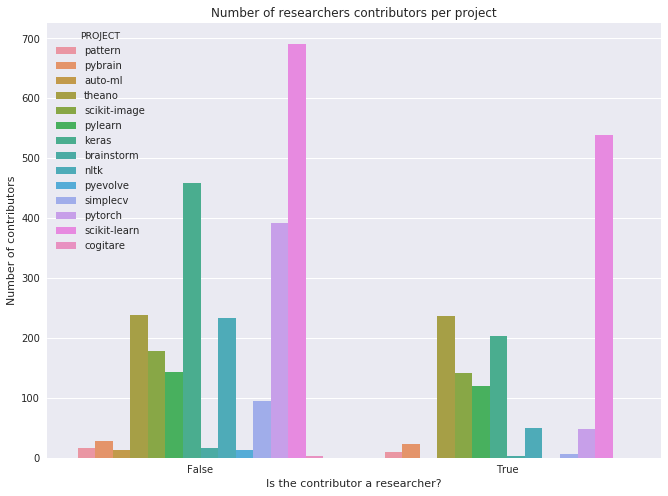

In [32]:
sns.countplot('IS_RESEARCHER', hue = 'PROJECT', data = all_commits.drop_duplicates(['PROJECT', 'AUTHOR_NAME']))

plt.title('Number of researchers contributors per project')
plt.xlabel('Is the contributor a researcher?')
plt.ylabel('Number of contributors');

In [42]:
def researcher_contributors(project_name, project_dataset):
    without_duplicates = project_dataset.drop_duplicates(['AUTHOR_NAME'])
    percents = 100 * without_duplicates.groupby(['IS_RESEARCHER'])['COMMIT_HASH'].count() / len(without_duplicates)
    
    
    researcher_contributors = '%.2f' % (percents[True] if True in percents.index else 0)
    non_researcher_contributors = '%.2f' % (percents[False] if False in percents.index else 0)
    
    print('Participation (in # of contributors) for project \'' + project_name + '\', there has been:')
    print(' -     Researcher contributors:', researcher_contributors + '%')
    print(' - Non researcher contributors:', non_researcher_contributors + '%')
    
for project_name in projects_commits.keys():
    researcher_contributors(project_name, projects_commits[project_name])
    print()

Participation (in # of contributors) for project 'pattern', there has been:
 -     Researcher contributors: 34.62%
 - Non researcher contributors: 65.38%

Participation (in # of contributors) for project 'pybrain', there has been:
 -     Researcher contributors: 45.10%
 - Non researcher contributors: 54.90%

Participation (in # of contributors) for project 'auto-ml', there has been:
 -     Researcher contributors: 0.00%
 - Non researcher contributors: 100.00%

Participation (in # of contributors) for project 'theano', there has been:
 -     Researcher contributors: 49.79%
 - Non researcher contributors: 50.21%

Participation (in # of contributors) for project 'scikit-image', there has been:
 -     Researcher contributors: 44.20%
 - Non researcher contributors: 55.80%

Participation (in # of contributors) for project 'pylearn', there has been:
 -     Researcher contributors: 45.63%
 - Non researcher contributors: 54.37%

Participation (in # of contributors) for project 'keras', there ha

### Les contributions viennent-elles majoritairement de contributeurs académiques ?

#### En nombre de *commits*

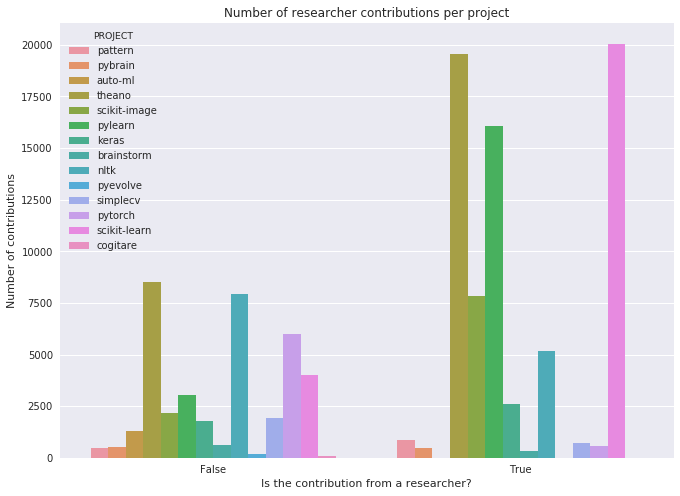

In [43]:
sns.countplot('IS_RESEARCHER', hue = 'PROJECT', data = all_commits)

plt.title('Number of researcher contributions per project')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of contributions');

In [44]:
def researcher_commits_contributions(project_name, project_dataset):
    percents = 100 * project_dataset.groupby(['IS_RESEARCHER']).size() / len(project_dataset)
    
    researcher_contribution = '%.2f' % (percents[True] if True in percents.index else 0)
    non_researcher_contribution = '%.2f' % (percents[False] if False in percents.index else 0)
    
    print('Participation (in # of commits) for project \'' + project_name + '\', there has been:')
    print(' -     Researcher contributors:', researcher_contribution + '%')
    print(' - Non researcher contributors:', non_researcher_contribution + '%')

for project_name in projects_commits.keys():
    researcher_commits_contributions(project_name, projects_commits[project_name])
    print()

Participation (in # of commits) for project 'pattern', there has been:
 -     Researcher contributors: 64.10%
 - Non researcher contributors: 35.90%

Participation (in # of commits) for project 'pybrain', there has been:
 -     Researcher contributors: 48.99%
 - Non researcher contributors: 51.01%

Participation (in # of commits) for project 'auto-ml', there has been:
 -     Researcher contributors: 0.00%
 - Non researcher contributors: 100.00%

Participation (in # of commits) for project 'theano', there has been:
 -     Researcher contributors: 69.68%
 - Non researcher contributors: 30.32%

Participation (in # of commits) for project 'scikit-image', there has been:
 -     Researcher contributors: 78.39%
 - Non researcher contributors: 21.61%

Participation (in # of commits) for project 'pylearn', there has been:
 -     Researcher contributors: 84.12%
 - Non researcher contributors: 15.88%

Participation (in # of commits) for project 'keras', there has been:
 -     Researcher contribut

#### En nombre de lignes ajoutées/retirées

In [46]:
def researcher_lines_contributions(project_name, project_dataset, field):
    percents = 100 * project_dataset.groupby(['IS_RESEARCHER'])[field].sum() / project_dataset[field].sum()
    
    researcher_contribution = '%.2f' % (percents[True] if True in percents.index else 0)
    non_researcher_contribution = '%.2f' % (percents[False] if False in percents.index else 0)
    
    print('Participation (in # of ' + field + ') for project \'' + project_name + '\', there has been:')
    print(' -     Researcher contributors:', researcher_contribution + '%')
    print(' - Non researcher contributors:', non_researcher_contribution + '%')

def researcher_added_lines_contributions(project_name, project_dataset):
    researcher_lines_contributions(project_name, project_dataset, 'ADDED_LINES')
    
def researcher_deleted_lines_contributions(project_name, project_dataset):
    researcher_lines_contributions(project_name, project_dataset, 'DELETED_LINES')
    
for project_name in projects_commits.keys():
    researcher_added_lines_contributions(project_name, projects_commits[project_name])
    print()
    
print()
print() 

for project_name in projects_commits.keys():
    researcher_deleted_lines_contributions(project_name, projects_commits[project_name])
    print()

Participation (in # of ADDED_LINES) for project 'pattern', there has been:
 -     Researcher contributors: 72.62%
 - Non researcher contributors: 27.38%

Participation (in # of ADDED_LINES) for project 'pybrain', there has been:
 -     Researcher contributors: 38.30%
 - Non researcher contributors: 61.70%

Participation (in # of ADDED_LINES) for project 'auto-ml', there has been:
 -     Researcher contributors: 0.00%
 - Non researcher contributors: 100.00%

Participation (in # of ADDED_LINES) for project 'theano', there has been:
 -     Researcher contributors: 79.29%
 - Non researcher contributors: 20.71%

Participation (in # of ADDED_LINES) for project 'scikit-image', there has been:
 -     Researcher contributors: 85.99%
 - Non researcher contributors: 14.01%

Participation (in # of ADDED_LINES) for project 'pylearn', there has been:
 -     Researcher contributors: 86.11%
 - Non researcher contributors: 13.89%

Participation (in # of ADDED_LINES) for project 'keras', there has been:

### Les contributeurs académiques sont-ils les contributeurs qui contribuent le plus  individuellement ?

Nous allons procéder à la constitution d'un set de données intermédiaire qui rassemble les contributions de chaque contributeur.

In [49]:
def decide_if_commit_made_by_researcher(row):
    global contributors_status
    
    row['IS_RESEARCHER'] = contributors_status['IS_RESEARCHER'][row['NAME']]
    
    return row

def compute_contributors_statistics(commits):
    statistics = pd.DataFrame(index = commits['AUTHOR_NAME'].unique())
    
    statistics['NUMBER_OF_COMMITS'] = 0
    statistics['ADDED_LINES'] = 0
    statistics['DELETED_LINES'] = 0
    statistics['MODIFIED_LINES'] = 0
    
    for index, row in commits.iterrows():
        name = row['AUTHOR_NAME']
        
        statistics['NUMBER_OF_COMMITS'][name] += 1
        statistics['ADDED_LINES'][name] += row['ADDED_LINES']
        statistics['DELETED_LINES'][name] += row['DELETED_LINES']
        statistics['MODIFIED_LINES'][name] += row['ADDED_LINES'] + row['DELETED_LINES']
        
    statistics['NAME'] = statistics.index
    
    statistics = statistics.apply(decide_if_commit_made_by_researcher, axis = 1)
    
    statistics.reset_index(drop = True, inplace = True)
        
    return statistics

projects_contributors = {}

for project_name in projects_commits.keys():
    contributors = compute_contributors_statistics(projects_commits[project_name])
    contributors['PROJECT'] = project_name
    
    projects_contributors[project_name] = contributors
    
contributors = pd.concat(projects_contributors.values())
contributors.reset_index(drop = True, inplace = True)

contributors.sample(5)

,NUMBER_OF_COMMITS,ADDED_LINES,DELETED_LINES,MODIFIED_LINES,NAME,IS_RESEARCHER,PROJECT
3606,1,6,5,11,Nitish Pandey,True,scikit-learn
573,5,75,7,82,Tony,True,scikit-image
546,7,53,8,61,vipulraheja,False,theano
1808,1,9,10,19,Denis Fedorenko,False,keras
3770,2,4,4,8,Vilhelm von Ehrenheim,False,scikit-learn


#### En nombre de *commits* par contributeur

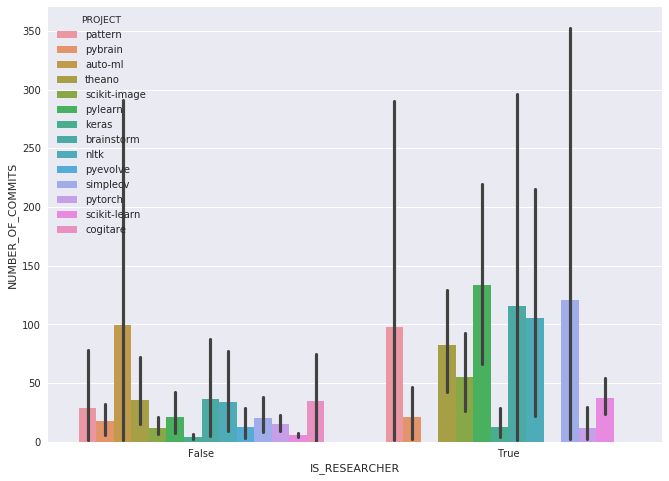

In [50]:
sns.barplot(x = 'IS_RESEARCHER', y = 'NUMBER_OF_COMMITS', hue = 'PROJECT', data = contributors)

#### En nombre de lignes ajoutées/retirées par contributeur

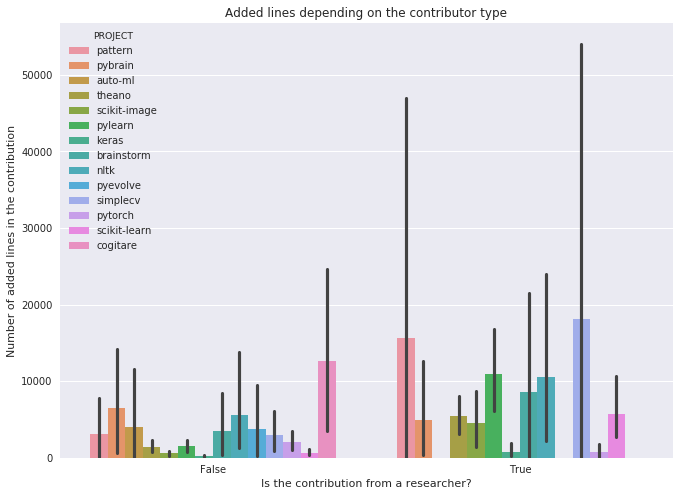

In [52]:
sns.barplot(x = 'IS_RESEARCHER', y = 'ADDED_LINES', hue = 'PROJECT', data = contributors)

plt.title('Added lines depending on the contributor type')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of added lines in the contribution');

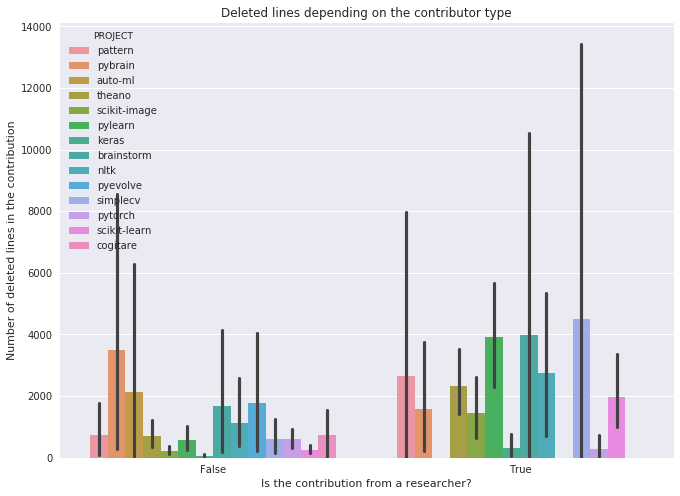

In [53]:
sns.barplot(x = 'IS_RESEARCHER', y = 'DELETED_LINES', hue = 'PROJECT', data = contributors)

plt.title('Deleted lines depending on the contributor type')
plt.xlabel('Is the contribution from a researcher?')
plt.ylabel('Number of deleted lines in the contribution');